In [1]:
import pandas as pd
import numpy as py

In [2]:
df = pd.read_csv('pokemon/pokemon.csv')
df.head(5)

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [4]:
path = 'pokemon/pokemon_jpg'

In [5]:
image_size=64
batch_size=64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

normal_dataset = ImageFolder(path, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats),
    T.RandomHorizontalFlip(p=0.5)
]))

# Augment the dataset with mirrored images

mirror_dataset = ImageFolder(path, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats),
    T.RandomHorizontalFlip(p=0.5)
]))

# Augment the dataset with color changes

color_jitter_dataset = ImageFolder(path, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ColorJitter(0.5, 0.5, 0.5),
    T.ToTensor(),
    T.Normalize(*stats)
]))

In [6]:
# Combine datasets

from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder

dataset_list = [normal_dataset, mirror_dataset, color_jitter_dataset]
dataset = ConcatDataset(dataset_list)

dataloader = DataLoader(dataset, batch_size, shuffle=True, 
                       num_workers=4, pin_memory=False)

In [7]:
def denorm(image):
    return image*stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataloader, nmax=64):
    for images, _ in dataloader:
        show_images(images, nmax)
        break

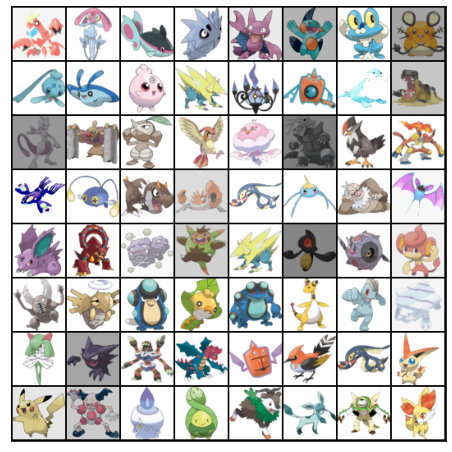

In [9]:
show_batch(dataloader)

In [64]:
## Discriminator Models
seed_size=16
model1 = nn.Sequential(
    # Input is 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 8 x 8
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [65]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
model.fc.out_features = 1
model

Using cache found in /Users/gym/.cache/torch/hub/pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [66]:
model2 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 128, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 8 x 8
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 64 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 32 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 64 x 64
)

## Model Testing

In [67]:
test_model_size = False

if test_model_size:
    seed_batch = torch.randn(batch_size, 16, 1, 1, device=device)
    
    generator=model2
    to_device(generator, device)
    fake_pokemon=generator(16)
    print(fake_pokemon.size())

## GPU Setup

In [68]:
def get_training_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [69]:
device = get_training_device()
device

device(type='cpu')

In [70]:
dev_dataloader = DeviceDataLoader(dataloader, device)

## Training Function

In [71]:
def train_discriminator(real_pokemon, disc_optimizer):
    disc_optimizer.zero_grad()
    real_predictions=discriminator(real_pokemon)
    real_targets=torch.rand(real_pokemon.size(0), 1, device= device)*(0.1-0)+0
    real_loss=F.binary_cross_entropy(real_predictions, real_targets)
    real_score=torch.mean(real_predictions).item()
    latent_batch=torch.randn(batch_size, 16, 1, 1, device=device)
    fake_pokemon=generator(latent_batch)
    gen_predictions=discriminator(fake_pokemon)
    gen_targets=torch.rand(fake_pokemon.size(0), 1, device=device)*(1-0.9)+0.9
    gen_loss=F.binary_cross_entropy(gen_predictions, gen_targets)
    gen_score=torch.mean(gen_predictions).item()
    
    total_loss=real_loss=gen_loss
    total_loss.backward()
    disc_optimizer.step()
    return total_loss.item(), real_score, gen_score

In [72]:
def train_generator(gen_optimizer):
    gen_optimizer.zero_grad()
    latent_batch=torch.randn(batch_size,16, 1, 1, device=device)
    fake_pokemon=generator(latent_batch)
    disc_predictions=discriminator(fake_pokemon)
    targets=torch.zeros(fake_pokemon.size(0), 1, device=device)
    loss=F.binary_cross_entropy(disc_predictions, targets)
    loss.backward()
    gen_optimizer.step()
    
    return loss.item()

## Results

In [73]:
import os
from torchvision.utils import save_image

result_dir = 'results'
os.makedirs(result_dir, exist_ok=True)

In [74]:
def save_results(index, latent_batch, show=True):
    fake_pokemon=generator(latent_batch)
    fake_file='result-image-{0:0=4d}.png'.format(index)
    
    save_image(denorm(fake_pokemon), os.path.join(result_dir, fake_file), nrow=8)
    print('Result Saved')
    
    if show:
        fig, ax=plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_pokemon.cpu(). detach(), nrow=8).permute(1, 2, 0))

## Full Training

In [95]:
fixed_latent_batch=torch.randn(64, 16, 1, 1, device=device)

def train(epochs, learning_rate, start_idx=1):
    torch.cuda.empty_cache()
    
    disc_lossed=[]
    disc_scores=[]
    gen_losses=[]
    gen_scores=[]
    
    disc_optimizer=torch.optim.Adam(discriminator.parameters(),
                                  lr=leaarning_rate, betas=(0.5, 0.9))
    gen_optimizer=torch.optim.Adam(discriminator.parameters(),
                                  lr=leaarning_rate, betas=(0.5, 0.9))
    
    for epoch in range(epochs):
        for real_img, _ in tqdm(dev_dataloader):
            disc_loss, real_score, gen_score=train_discriminator(real_img, disc_optimizer)
            gen_loss=train_generator(gen_optimizer)
            
        disc_lossed.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)
    
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
        epoch+start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))
        
        save_results(epoch + start_idx, fixed_latent_batch, show=False)
        
        return disc_lossed, disc_scores, gen_losses, gen_scores

In [96]:
dev_dataloader = DeviceDataLoader(dataloader, device)

## Model Selection

In [97]:
def debug_memory():
    import collections, gc, resource, torch
    print('maxrss = {}'.format(
        resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))
    tensors = collections.Counter((str(o.device), o.dtype, tuple(o.shape))
                                  for o in gc.get_objects()
                                  if torch.is_tensor(o))
    for line in tensors.items():
        print('{}\t{}'.format(*line))

In [98]:
discriminator = model1
discriminator = to_device(discriminator, device)

generator = model2
generator = to_device(generator, device)

In [ ]:
# leaarning_rate = 0.00275
epochs = 10

history = train(epochs, leaarning_rate)